In [3]:
pip install torchbnn


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install uncertainties

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn 
from torchbnn.modules import linear

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from uncertainties import ufloat

In [6]:
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)


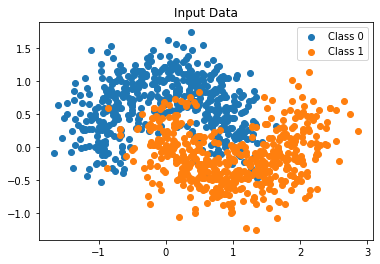

In [7]:
print()
plt.scatter(X[y == 0, 0],X[y==0,1],label='Class 0')
plt.scatter(X[y == 1, 0],X[y==1,1],label='Class 1')
plt.title("Input Data")
plt.legend()

In [8]:
#Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) #Expanding from 1 dimension to two

In [9]:
print(X.ndim,y.ndim)

2 2


In [10]:
#Create Bayesian Neural Network

class bnn(nn.Module):
    def __init__(self):
        super(bnn, self).__init__()
        #Input: 2
        #Two hidden layers with 8 neurons each
        #1 output layer
        self.fc1 = linear.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=8)
        self.fc2 = linear.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=8, out_features=8)
        self.fc3 = linear.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=8, out_features=1)
        
        #Forward function
    def forward(self, x):
        #Using relu activation function
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
        


In [11]:
# Initialize the model, loss function, and optimizer
model = bnn()
loss_func = nn.BCELoss() #Binary Cross Entropy loss function
optimizer = optim.Adam(model.parameters(), lr=0.01) #Adam optimizer with learning rate = 0.01

In [12]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
losses=[]
#Training model
epochs = 10000
for epoch in range(epochs):
    y_pred = model.forward(X_train)
    
    loss = loss_func(y_pred,y_train)
    losses.append(loss.detach().numpy())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [0/10000], Loss: 0.8289
Epoch [100/10000], Loss: 0.3291
Epoch [200/10000], Loss: 0.3085
Epoch [300/10000], Loss: 0.2515
Epoch [400/10000], Loss: 0.2513
Epoch [500/10000], Loss: 0.2261
Epoch [600/10000], Loss: 0.2306
Epoch [700/10000], Loss: 0.2196
Epoch [800/10000], Loss: 0.2222
Epoch [900/10000], Loss: 0.2059
Epoch [1000/10000], Loss: 0.2091
Epoch [1100/10000], Loss: 0.2041
Epoch [1200/10000], Loss: 0.2057
Epoch [1300/10000], Loss: 0.1974
Epoch [1400/10000], Loss: 0.2005
Epoch [1500/10000], Loss: 0.1973
Epoch [1600/10000], Loss: 0.1944
Epoch [1700/10000], Loss: 0.1968
Epoch [1800/10000], Loss: 0.1948
Epoch [1900/10000], Loss: 0.1933
Epoch [2000/10000], Loss: 0.1923
Epoch [2100/10000], Loss: 0.1919
Epoch [2200/10000], Loss: 0.1924
Epoch [2300/10000], Loss: 0.1941
Epoch [2400/10000], Loss: 0.1919
Epoch [2500/10000], Loss: 0.1912
Epoch [2600/10000], Loss: 0.1947
Epoch [2700/10000], Loss: 0.1891
Epoch [2800/10000], Loss: 0.1877
Epoch [2900/10000], Loss: 0.1880
Epoch [3000/10000], Lo

Text(0.5, 0, 'Epochs')

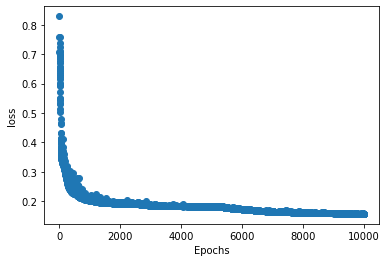

In [14]:
#print(np.asarray(losses))

plt.scatter(range(epochs),np.asarray(losses))
plt.ylabel('loss')
plt.xlabel('Epochs')

In [15]:
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),np.arange(y_min, y_max, 0.01))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
print(x_min, x_max)

tensor(-2.1690) tensor(3.3639)


In [16]:
n_passes = 100
predictions = torch.zeros(n_passes, len(grid))

In [17]:
model.eval()
with torch.no_grad():
    for i in range(n_passes):
        predictions[i] = model(grid).squeeze()
        


In [18]:
mean_preds = predictions.mean(0).numpy().reshape(xx.shape)
std_preds = predictions.std(0).numpy().reshape(xx.shape)


Text(0.5, 1.0, 'Mean Probability Surface')

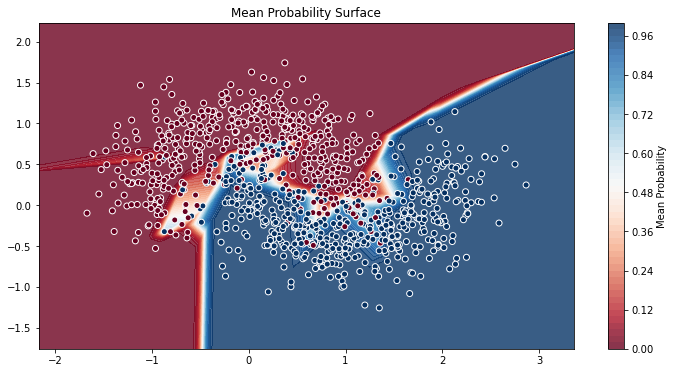

In [19]:
plt.figure(figsize=(12, 6))
plt.contourf(xx, yy, mean_preds, levels=50, cmap="RdBu", alpha=0.8)
plt.colorbar(label='Mean Probability')
plt.scatter(X[:, 0], X[:, 1], c=y[:, 0], cmap="RdBu", edgecolor="white", marker="o")
plt.title("Mean Probability Surface")

Text(0.5, 1.0, 'Uncertainty Surface')

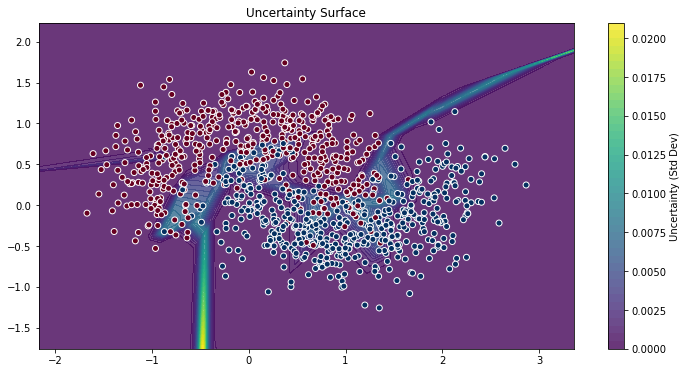

In [20]:
plt.figure(figsize=(12, 6))
plt.contourf(xx, yy, std_preds, levels=50, cmap="viridis", alpha=0.8)
plt.colorbar(label='Uncertainty (Std Dev)')
plt.scatter(X[:, 0], X[:, 1], c=y[:, 0], cmap="RdBu", edgecolor="white", marker="o")
plt.title("Uncertainty Surface")


In [41]:
def calculate_accuracy_with_uncertainty(model, X, y, threshold=0.5, n_samples=200):
    model.eval()
    accuracies = []
    
    with torch.no_grad():
        for _ in range(n_samples):
            outputs = model(X)
            predicted = (outputs >= threshold).float()
            correct = (predicted == y).float().sum()
            accuracy = correct / y.shape[0]
            accuracies.append(accuracy.item())
    
    accuracies = np.array(accuracies)
    mean_accuracy = accuracies.mean()
    accuracy_uncertainty = accuracies.std()
    
    return mean_accuracy, accuracy_uncertainty

# Calculate accuracy with uncertainty on the test set

mean_accuracy, accuracy_uncertainty = calculate_accuracy_with_uncertainty(model, X_test, y_test)
print(f'Accuracy on test set: {mean_accuracy * 100:.2f}% ± {accuracy_uncertainty * 100:.2f}%')

Accuracy on test set: 90.25% ± 0.19%
